# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.api import OLS

In [2]:
lc_census_merged = pd.read_csv('../data/2014_loan_data/pct_accepted_by_zip3_2014_ALL.csv', dtype={'zip_3':str})
all_loans_2014 = pd.read_csv('../hugo/all_loans_2014', dtype={'ZIP':str}, low_memory = False)
all_loans_2015 = pd.read_csv('../hugo/all_loans_2015', dtype={'ZIP':str}, low_memory = False)
census = pd.read_csv('../data/census_zip3.csv', dtype={'zip_3':str})

In [3]:
all_loans_2014_merged = all_loans_2014.merge(census, "left", left_on="ZIP", right_on="zip_3")
all_loans_2015_merged = all_loans_2015.merge(census, "left", left_on="ZIP", right_on="zip_3")

# What variables should we care about?

[Legally protected classes](https://content.next.westlaw.com/Document/Ibb0a38daef0511e28578f7ccc38dcbee/View/FullText.html?contextData=sc.Default&transitionType=Default&firstPage=true&bhcp=1):
* Race
* Color
* Religion or creed
* National origin or ancestry
* Sex
* Age
* Physical or mental disability
* Veteran status
* Genetic information
* Citizenship

Characteristics that are protected by being an Equal Housing Lender, which Lending Club is:
* Race
* Color
* Religion
* National origin
* Sex
* Handicap
* Familial status

Other variables research suggests is correlated to socioeconomic status and other important socio-political outcomes:
* **Education**
* Unemployment
* Poverty
* Income/wealth

<hr>
Variables we have through Lending Club (individual-level fairness):
* Income (`annual_inc_joint`, `annualInc`)
* Loan description (could be used to back out loans for families, for instance) (`desc`)
    * This is something we'd need text analysis for, probably beyond our scope
* Debt-to-income ratio (`dti`)
* Number of mortgage accounts (could be used to back out loans for families) (`mortAcc`)
* Job description (`emp_title`)

Variables that we have through the Census (group-level fairness): 
* Race
* Education
* Family status
* Gender x age
* Unemployment rate
* Workforce
* Household income

<hr>

Synthesizing, it seems like these are our best options for proceeding:

| Type | Features |
| --- | --- |
| Individual-level fairness | *Income* |
| Group-level fairness | *Race, family status, education, unemployment* |

Will consider both **post-hoc** adjustments to achieve fairness (statistical/conditional parity, calibration/predictive equality) and **built-in** fairness features (adjusting the loss function to balance loss by a group of interest).

# Individual-level fairness

* just using reject data, see if people in same zip codes with different dti, risk scores, employment lengths are rejected differently
* histograms for dti and risk score and bar charts for employment

Going to need more full data set to do this, not the scaled back one we have here (i.e., all columns).

# Group-level fairness

In [23]:
def plot_proba_distr_quantiles(col, ax):
    tiles = np.percentile(all_loans_2014_merged[col].dropna(), [0,25,50,75,100])
    _0_25 = all_loans_2014_merged[col] < tiles[1]
    _25_50 = (all_loans_2014_merged[col] < tiles[2]) & (all_loans_2014_merged[col] > tiles[1])
    _50_75 = (all_loans_2014_merged[col] < tiles[3]) & (all_loans_2014_merged[col] > tiles[2])
    _75_100 = (all_loans_2014_merged[col] < tiles[4]) & (all_loans_2014_merged[col] > tiles[3])

    sns.kdeplot(all_loans_2014_merged.proba[_0_25==True].dropna(), color="green", label="0-25", alpha=0.5, ax=ax)
    sns.kdeplot(all_loans_2014_merged.proba[_25_50==True].dropna(), color="purple", label="25-50", alpha=0.5, ax=ax)
    sns.kdeplot(all_loans_2014_merged.proba[_50_75==True].dropna(), color="orange", label="50-75", alpha=0.5, ax=ax)
    sns.kdeplot(all_loans_2014_merged.proba[_75_100==True].dropna(), color="blue", label="75-100", alpha=0.5, ax=ax)
    ax.set_xlabel(col, fontsize=25)
    ax.set_title(r"Distribution of $P(default)$", fontsize=30)
    ax.legend(fontsize=25)

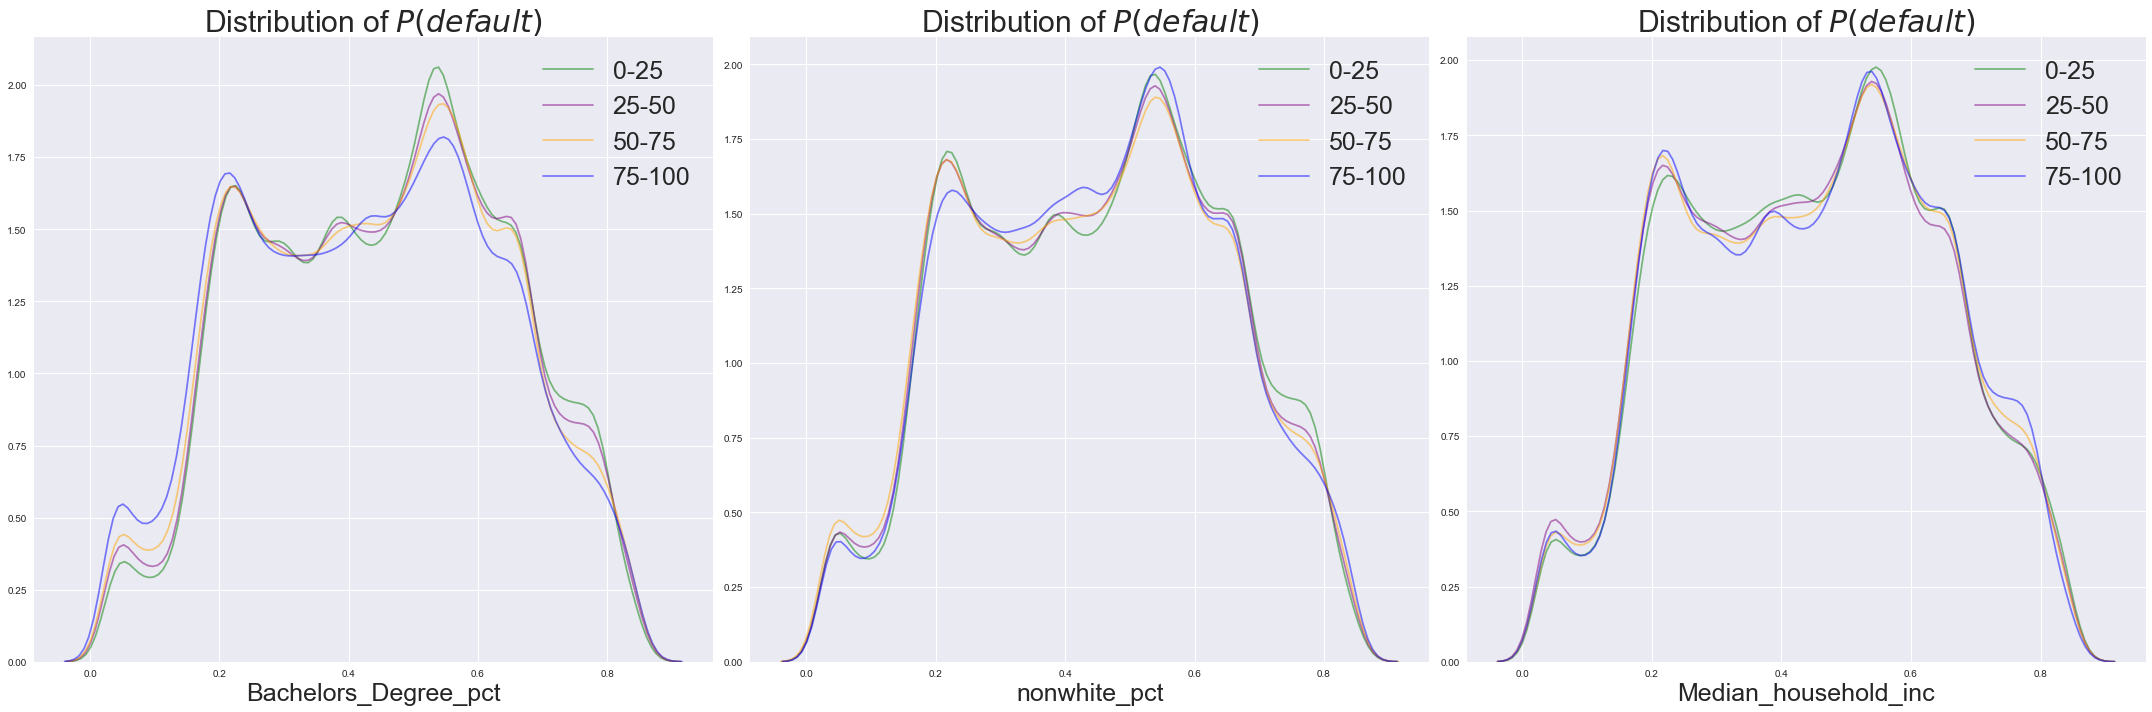

In [26]:
fig, ax = plt.subplots(1,3, figsize=(30,10))
plot_proba_distr_quantiles('Bachelors_Degree_pct', ax[0])
plot_proba_distr_quantiles('nonwhite_pct', ax[1])
plot_proba_distr_quantiles('Median_household_inc', ax[2])
plt.tight_layout()